In [1]:
import torch
from board import move
from board import create_action_mask
import torch.nn as nn


/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model import BoardTransformer, BoardGFLowNet
from board import random_board, get_reward

## Tokens:
- 0: begin
- 1: stop
- 2: up
- 3: down
- 4: left
- 5: right

In [3]:
lr = 1e-6
decoder_layers = 2
encoder_layers = 2
embed_dim = 8
d_ff=8
n_heads = 4
batch_size = 16
gfn = BoardGFLowNet(embed_dim, d_ff, n_heads, encoder_layers, decoder_layers, 6)

In [4]:
from main import loss_fn

In [27]:
optimizer = torch.optim.AdamW(gfn.parameters(), lr=1e-3)

In [40]:
total_reward =0
trials = 100
for i in range(trials):
    boards = random_board().unsqueeze(0)
    total_reward += get_reward(boards)

print(total_reward/trials)

tensor([0.2994])


In [1]:
import random

8

In [28]:
boards = random_board().unsqueeze(0)
# boards = torch.stack([random_board() for _ in range(128)])
moves = torch.zeros(1,1).type(torch.LongTensor)

In [29]:

loss_history = []
reward_history = []

In [30]:
import torch

In [31]:
from torch.distributions.categorical import Categorical

In [33]:
batch_size = 256
for epoch in range(1000):
    total_loss = 0
    total_reward = 0
    for sample in range(batch_size):

        boards = random_board().unsqueeze(0)
        moves = torch.zeros(1,1).type(torch.LongTensor)
        forward_probabilities = []
        for i in range(100):
            logz, logits = gfn(boards, moves)
            if(i == 0):
                starting_logz = logz

            logits = logits[0, -1, :]
            mask = create_action_mask(boards[0])
            logits = torch.softmax(mask * logits, dim=0)
            
            new_moves = torch.LongTensor([Categorical(logits.squeeze()).sample()])
            
            if(new_moves == 0):
                continue

            forward_probabilities.append(logits[new_moves])
            moves = torch.cat([moves, new_moves.unsqueeze(0)], dim=1)
            boards = boards.clone()
            for index, board in enumerate(boards):
                boards[index] = move(board, new_moves[index])
            if(new_moves[0] == 1):
                break
        
        reward = get_reward(boards)
        total_reward += reward
        loss = loss_fn(starting_logz, reward, forward_probabilities)
        # print('loss: ', loss)
        loss.backward(retain_graph=True)
        if(sample == -1):
            for name, param in gfn.named_parameters():
                print(name, ':', param)
            print('\n\n')
        total_loss += loss
    
    for param in gfn.logZ_predictor.parameters():
        param.grad *= 10
    
    optimizer.step()
    optimizer.zero_grad()
    print(f'Epoch {epoch}, loss: {total_loss/batch_size}, reward: {total_reward/batch_size}')
    loss_history.append((total_loss/batch_size).item())
    reward_history.append((total_reward/batch_size).item())

Epoch 0, loss: tensor([[55.5907]], grad_fn=<DivBackward0>), reward: tensor([0.2918])
Epoch 1, loss: tensor([[43.6986]], grad_fn=<DivBackward0>), reward: tensor([0.2812])
Epoch 2, loss: tensor([[61.4325]], grad_fn=<DivBackward0>), reward: tensor([0.3019])


KeyboardInterrupt: 

In [2]:
import wandb

In [6]:
import torch

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
board = torch.arange(16).reshape(4,4)

In [58]:
from board import create_action_mask

In [59]:
create_action_mask(board)

tensor([0., 1., 0., 1., 1., 0.])

In [56]:
def create_action_mask(board):
    gap_coord = torch.where(board == 0)
    mask = torch.ones(6)
    mask[:2] = 0
    

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [54]:
for i in range(10):
    print(torch.multinomial(torch.Tensor([0,0,0,0,0,1]), num_samples=1))

tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])
tensor([5])


In [9]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'reward history')

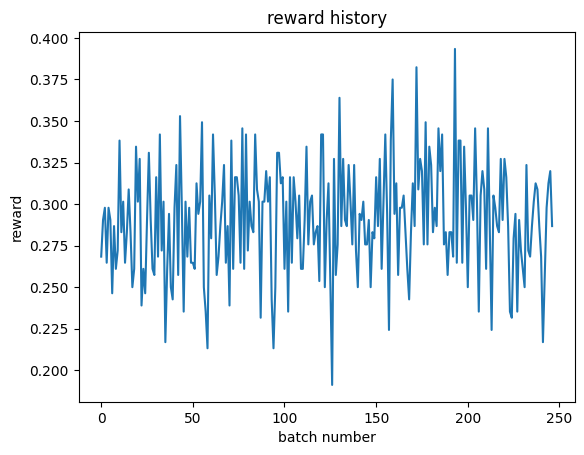

In [28]:
plt.plot(reward_history)
plt.xlabel('batch number')
plt.ylabel('reward')
plt.title('reward history')

Text(0.5, 1.0, 'loss history')

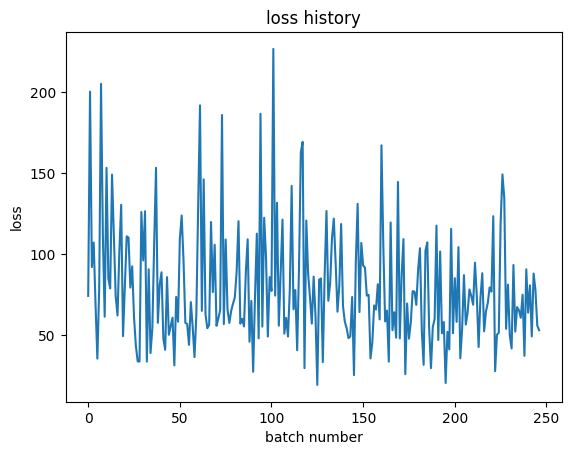

In [29]:

plt.plot(loss_history)

plt.xlabel('batch number')
plt.ylabel('loss')
plt.title('loss history')